In [1]:
import pandas as pd
import json
import os
import pylab as pl
import geopandas as gp
import glob
import zipfile
from sklearn.cluster import KMeans
from matplotlib import cm
from descartes import PolygonPatch
import scipy.cluster as scp
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster as scp


s = json.load( open(os.getenv ('PUI2015')+"/fbb_matplotlibrc.json") )
pl.rcParams.update(s)
pl.rcParams['font.size'] = 22.
pl.rcParams['font.family'] = 'serif'
pl.rcParams['font.serif'] = ['Times']#Computer Modern Roman']
pl.rcParams['font.weight'] = 'bold'
pl.rcParams['text.usetex'] = True
pl.rcParams['axes.labelsize'] = 20
pl.rcParams['xtick.labelsize'] = 20.
pl.rcParams['ytick.labelsize'] = 18.
pl.rcParams['xtick.major.size']= 10.
pl.rcParams['xtick.minor.size']= 5.
pl.rcParams['ytick.major.size']= 10.
pl.rcParams['ytick.minor.size']= 5.


%pylab inline

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python3.5/site-packages/matplotlib-2.0.0b4+2344.g7b27a1b-py3.5-macosx-10.6-x86_64.egg/matplotlib/__init__.py:910: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
//anaconda/lib/python3.5/site-packages/matplotlib-2.0.0b4+2344.g7b27a1b-py3.5-macosx-10.6-x86_64.egg/matplotlib/__init__.py:910: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


!wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip

!wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp01totals.zip

In [2]:
#http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981
nyczipsshp = gp.read_file("nyc-zip-code-tabulation-areas-polygons.geojson").\
    drop_duplicates(subset='postalCode')
print (len(np.unique(nyczipsshp.postalCode)), len(nyczipsshp.postalCode))
nyczips = nyczipsshp.postalCode.values.astype(int)
print ("number of NYC zip codes:", len(nyczips))

247 247
number of NYC zip codes: 247


In [3]:
print (type(nyczips[0]))

<class 'numpy.int64'>


In [4]:
#creating an new array of size Nzips X Nyears to store the data
cbs = np.zeros((len(nyczips), 2014-1994))
#creating a date range: 1994-2014
timeline = pd.date_range('1994', '2014', freq='A')
cbs.shape

(247, 20)

In [5]:
#glob is a module that allows me to see what files exist locally

allfiles =  np.array(glob.glob('zb*zip'))
print (allfiles)

['zbp00totals.zip' 'zbp01totals.zip' 'zbp02totals.zip' 'zbp03totals.zip'
 'zbp04totals.zip' 'zbp05totals.zip' 'zbp06totals.zip' 'zbp07totals.zip'
 'zbp08totals.zip' 'zbp09totals.zip' 'zbp10totals.zip' 'zbp11totals.zip'
 'zbp12totals.zip' 'zbp13totals.zip' 'zbp14totals.zip' 'zbp94totals.zip'
 'zbp95totals.zip' 'zbp96totals.zip' 'zbp97totals.zip' 'zbp98totals.zip'
 'zbp99totals.zip']


In [6]:
#looping over all years i extract the last 2 digits if the year, 
#read in the file with that name (unzipping on the spot)
#into a numpy 2D array cbs i use caps or not caps, depending on the file, 
#to extract ZIP and EST
for j,yy in enumerate(range(1994, 2014)):
    #print (("%d"%yy)[2:])
    print ('zbp' + ("%d"%yy)[2:])
    indx = np.array([("%d"%yy)[2:] in allfiles[i] for i in range(len(allfiles))])
    print (indx, allfiles[indx])
    if sum(indx)<1: continue
    f = allfiles[indx][0]
    
    #allfiles[np.array([("%d"%yy)[2:] \
        #                   in allf for allf in allfiles])][0]
    #print f
    zf = zipfile.ZipFile(f)
    df = pd.read_csv(zf.open(f.replace('.zip','.txt')))
    #print (df.head())
    if 'ZIP' in df.columns:
        z = 'ZIP'
        est = 'EST'
    else : 
        z = 'zip'
        est = 'est'
        
    
    for i,zp in enumerate(nyczips):
        try:
            cbs[i][j] = (df[df[z]==zp][est]).get_values()[0]
        except:
            cbs[i][j] = -1
        

zbp94
[False False False False False False False False False False False False
 False False False  True False False False False False] ['zbp94totals.zip']
zbp95
[False False False False False False False False False False False False
 False False False False  True False False False False] ['zbp95totals.zip']
zbp96
[False False False False False False False False False False False False
 False False False False False  True False False False] ['zbp96totals.zip']
zbp97
[False False False False False False False False False False False False
 False False False False False False  True False False] ['zbp97totals.zip']
zbp98
[False False False False False False False False False False False False
 False False False False False False False  True False] ['zbp98totals.zip']
zbp99
[False False False False False False False False False False False False
 False False False False False False False False  True] ['zbp99totals.zip']
zbp00
[ True False False False False False False False False False Fal

In [7]:
# i will look for data rows now. 
# the stanrard clustering packages cannot deal with NaNs
# i am taking the standard deviation row by row in cbs
# if the rows contain NaN the std will be NaN: std(cbs, 1)>0 is False
cleancsb = cbs[std(cbs, 1)>0]
cleannyczips = np.array(nyczips)[std(cbs, 1)>0]
badzips =  np.where(~(std(cbs, 1)>0))[0]
np.random.seed(222)

In [8]:
##important! to perform K-means normally i would whiten the data, 
#but for time series where i want to cluster on correlated behavior 
#of the variables (the time stamps here) I cannot whiten.
# i will instead normalize and standardize each observation (each zip)

vals = ((cleancsb.T - cleancsb.mean(1))/cleancsb.std(1)).T

print ("i expect means of each row to be = 0", vals.mean(1)[:10])
print ("i expect stds of each row to be = 1", vals.std(1)[:10])


i expect means of each row to be = 0 [ -6.43929354e-16  -2.66453526e-16  -6.88338275e-16   1.66533454e-16
  -6.66133815e-16  -2.88657986e-16   2.22044605e-17   6.66133815e-16
  -2.10942375e-16   2.22044605e-16]
i expect stds of each row to be = 1 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [9]:
# i tried a few options for number of clusters and settled on 5 
#by visual inspection of the clusters and of the variance (silouette plot)
nc = 5

km = KMeans(n_clusters=nc)


km.fit(vals)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

cluster centers


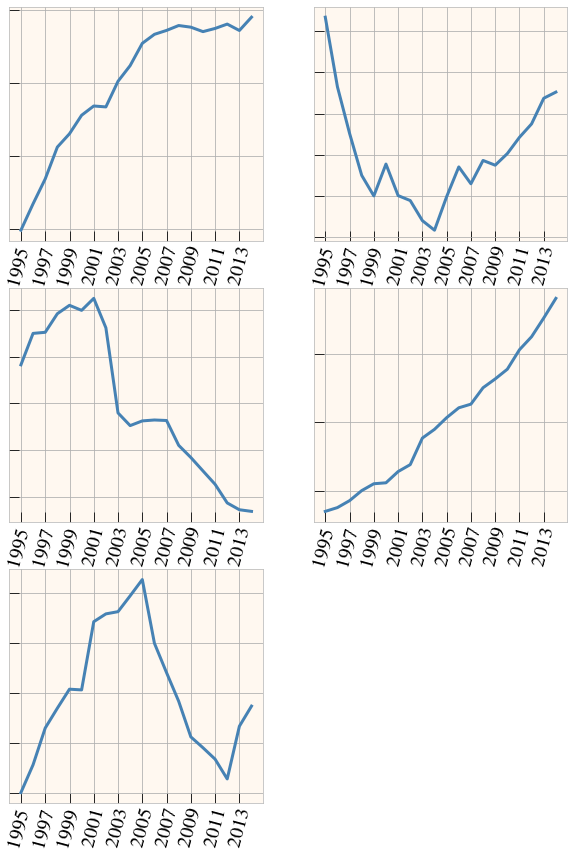

In [10]:
import pylab as pl
fig = pl.figure(figsize = (10,25))
for i,Xc in enumerate(km.cluster_centers_):
    ax = fig.add_subplot(5,2,(i+1))
    ax.plot(timeline, Xc)

    
    pl.xticks(fontsize = 20, rotation=75)
    ax.set_yticklabels([''*len(ax.get_xticklabels())])
print ("cluster centers")

In [11]:
for j in range(5):
    print ("zipcodes in cluster", j, )
    print (cleannyczips[km.labels_==j])
    print ("\n\n\n\n")
    
clustersdf = gp.GeoDataFrame()
clustersdf['postalCode'] = cleannyczips
clustersdf['cluster'] = km.labels_

zipcodes in cluster 0
[11374 11423 11432 11415 11433 11230 10466 10040 10473 10024 10025 11357
 11360 10128 11371 10023 10028 11102 10001 10011 10014 10012 11412 10005
 11430 11239 11209 10304 10314 11096 11697 10309 10280 10055 10112 10119
 10278 10286 10282]





zipcodes in cluster 1
[11426 10471 10470 11005 11236 10310 10168 10105 10153 10177 10154 10104
 10106 10158 10120 10155 10196 10275 10203]





zipcodes in cluster 2
[10021 10017 10010 10013 10006 10048 10165 10118 10176 10019 10111 10122
 10107 10103 10166 10169 10172 10152 10270 10110 10175 10151 10173 10178
 10121 10123 10022 10096 10265 10047 10260 10285 10281]





zipcodes in cluster 3
[11372 11004 11040 11365 11373 11001 11375 11427 11366 11428 11379 11429
 11435 11418 11221 11421 11419 11434 11216 11416 11233 11436 11213 11212
 11225 11218 11226 11219 11210 11204 10467 10463 10475 10469 10468 10458
 10034 10033 10462 10453 10465 10461 10457 10460 10032 10452 10456 10472
 10031 10039 10459 10451 10030 10027 10474 1045

(0.0, 1.0, 0.0, 1.0)

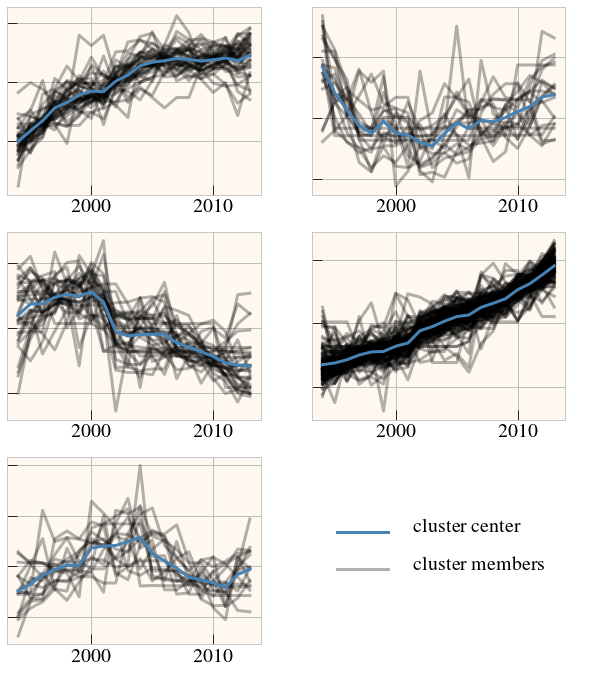

In [12]:

fig = pl.figure(figsize = (10,20))
for i,Xc in enumerate(km.cluster_centers_):
    ax = fig.add_subplot(5,2,(i+1))
    
    for v in vals[km.labels_ == i]:
        ax.plot(np.arange(1994,2014, 1),v, 'k-', alpha = 0.3)


    ax.set_yticklabels([''*len(ax.get_xticklabels())])
    ax.plot(np.arange(1994,2014, 1), Xc, lw=3)
    pl.xticks(fontsize = 20)
    ax.set_xlim(1993.1, 2013.9)
ax = fig.add_subplot(5,2,i+2)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([0.1,0.3], [0.4,0.4], 'k-', alpha = 0.3)
ax.plot([0.1,0.3], [0.6,0.6], '-')
ax.text(0.4, 0.6, "cluster center", fontsize=20)
ax.text(0.4, 0.4, "cluster members", fontsize=20)
ax.axis('off')

In [13]:
#adding postal codes to notebook
nyczipsshp.postalCode = nyczipsshp.postalCode.astype(int)
print (nyczipsshp.columns)
print (clustersdf.columns)

Index(['@id', 'BLDGpostalCode', 'CTY_FIPS', 'OBJECTID', 'PO_NAME', 'STATE',
       'ST_FIPS', 'Shape_Area', 'Shape_Leng', 'borough', 'geometry',
       'postalCode'],
      dtype='object')
Index(['postalCode', 'cluster'], dtype='object')


In [14]:
#i end up with a lower number of postal codes in the merged df
mergednyz = nyczipsshp.merge(clustersdf, on='postalCode', how='inner')
print (len(mergednyz.postalCode), len(np.unique(clustersdf.postalCode)), len(np.unique(nyczipsshp.postalCode)))

244 244 247


//anaconda/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
//anaconda/lib/python3.5/site-packages/geopandas/plotting.py:229: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


(-74.283564678453331,
 -73.67179689147234,
 40.474873729366841,
 40.93613362698175)

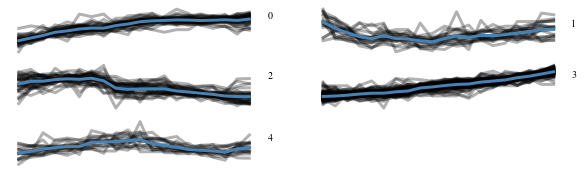

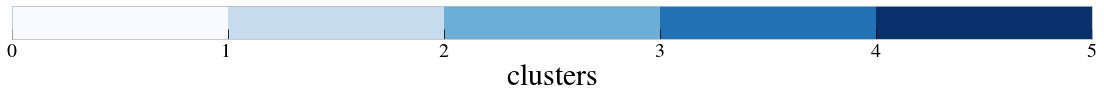

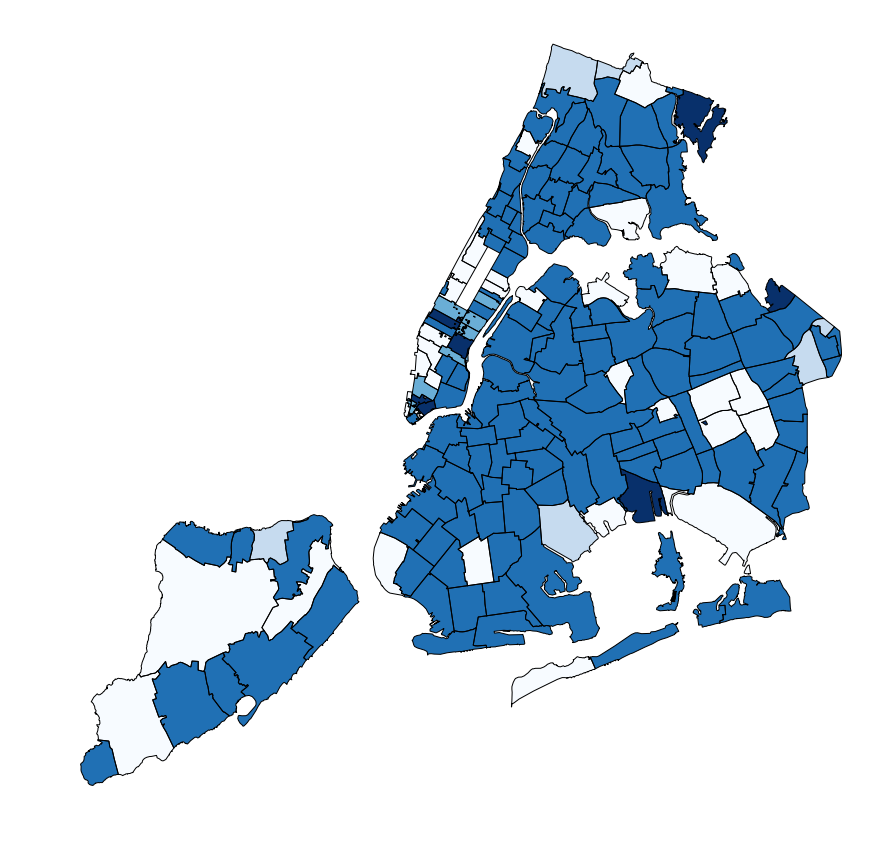

In [15]:
fig = pl.figure(figsize = (10,5))
for i,Xc in enumerate(km.cluster_centers_):
    ax = fig.add_subplot(5,2,(i+1))
    
    for v in vals[km.labels_ == i]:
        ax.plot(np.arange(1994,2014, 1),v, 'k-', alpha = 0.3)
    ax.text(2014.5, 1, "%d"%i)

    pl.xticks(fontsize = 10)
    ax.set_yticklabels([''*len(ax.get_xticklabels())])
    ax.plot(np.arange(1994,2014, 1), Xc, lw=3)
    pl.grid(False)
    pl.axis('off')
fig = pl.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=5)

#adding a color bar to identify the clusters on the map
# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar. 
bounds = range(nc+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                ticks=bounds,
                                spacing='uniform',
                                orientation='horizontal')
cb3.set_label('clusters', fontsize=30)
ax = pl.figure(figsize=(15,15)).add_subplot(111)
mergednyz.plot(column='cluster', colormap='Blues', alpha = 1, axes=ax)
ax.axis('off')

#comments
there are 2 upword trends indicating economic growth: one that is increasing at constant rate (cluster 3) to which most of NYC belongs, and one which flattens in 2005 (0) which includes  a number of ZIPs spread out through the boroughs: SI, the Rockaways, Queens, Upper West Side. 

There are 2 clusters with downward developement trends (2 and 4, although 4 seems to pick up in 2011, but that may very well be not significant). The financial district, as well as ZIPs in mid town seem to have lost business. 

Of course this is only a proxy for echonomic growth, and a poor one for sure: this does not weight differently large and small businesses, so if a large company (e.g. Google) were to open, and take a large portion of a zip code, this would not be interpreted as echonomic growth since it is only one establishment. 

The choice of 5 clusters is relatively arbitraty (i did some testing on the slope of the variance as a function of number of cluters and that is not a robust metric, although probably the best one) but the clusters seem farily tight despite the large scatter in each time series. Since K-means is not a deterministic algorithm, I ran it several times to see if a different starting point (initial centers) would lead to a different clustering, and the clustering seems in fact stable. 

Since K-means is not a particularly sophisticated algorithm, and I do not have a very large dataset, I can certainly afford to test with another algorithm. I will use hierarchical agglomerative clustering. 

In [16]:

xs = nyczipsshp['geometry'].centroid.apply(lambda i: i.x)
ys = nyczipsshp['geometry'].centroid.apply(lambda i: i.y)
xlim = [xs.min() - 0.1*(xs.max()-xs.min()),xs.max() + 0.1*(xs.max()-xs.min())]
ylim = [ys.min() - 0.1*(ys.max()-ys.min()),ys.max() + 0.1*(ys.max()-ys.min())]


In [17]:
dx = xlim[1]-xlim[0]
dy = ylim[1]-ylim[0]
if dx>dy:
    ylim[0] -= 0.5*(dx-dy)
    ylim[1] += 0.5*(dx-dy)
else:
    xlim[0] -= 0.5*(dy-dx)
    xlim[1] += 0.5*(dy-dx)



(0.0, 1.0, 0.0, 1.0)

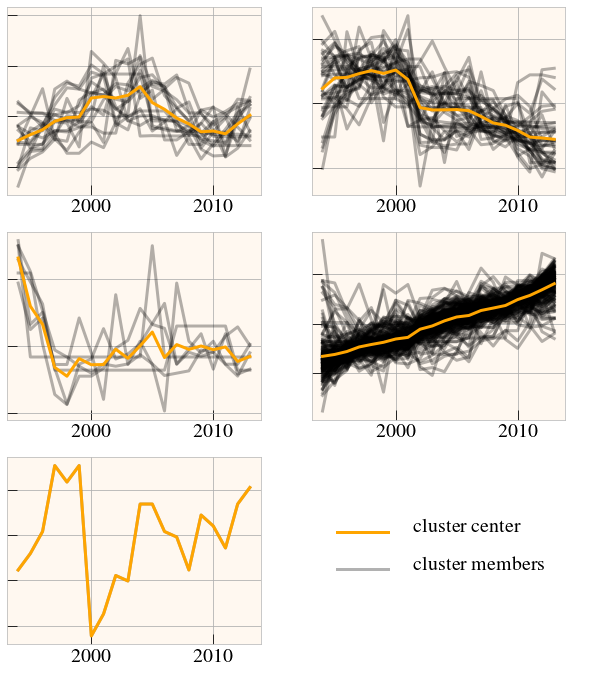

In [18]:
#choosing the same number of clusters as I had in the K-means
agc = AgglomerativeClustering(n_clusters=nc,  
                              linkage='average').fit(vals)
labelsag = agc.labels_
centroidsag = np.zeros((nc, vals.shape[1]))

def getCentroid(points):
    #print points[:,0], np.nanmean(points[:,0])
    return points.mean(axis=0)
                    
#colorsc3 = get_colors(np.arange(30), pl.cm.blues)
#colors3 = get_colors(labelsag, pl.cm.blues)
for i in labelsag:
    centroidsag[i] = getCentroid(vals[labelsag == i])


fig = pl.figure(figsize = (10,20))
for i,Xc in enumerate(centroidsag):
    ax = fig.add_subplot(5,2,(i+1))
    
    for v in vals[labelsag == i]:
        ax.plot(np.arange(1994,2014, 1),v, 'k-', alpha = 0.3)


    ax.set_yticklabels([''*len(ax.get_xticklabels())])
    ax.plot(np.arange(1994, 2014, 1), Xc, color="Orange", lw=3)
    pl.xticks(fontsize = 20)
    ax.set_xlim(1993.1, 2013.9)
    
ax = fig.add_subplot(5, 2, i+2)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.plot([0.1, 0.3], [0.4, 0.4], 'k-', alpha = 0.3)
ax.plot([0.1, 0.3], [0.6, 0.6], '-', color='Orange')
ax.text(0.4, 0.6, "cluster center", fontsize=20)
ax.text(0.4, 0.4, "cluster members", fontsize=20)
ax.axis('off')    
    


In [19]:
for j in range(5):
    print ("zipcodes in cluster", j, )
    print (cleannyczips[labelsag==j])
    print ("\n\n\n\n")
    
clustersdf = gp.GeoDataFrame()
clustersdf['postalCode'] = cleannyczips
clustersdf['cluster'] = labelsag

zipcodes in cluster 0
[11451 10464 10036 10020 10016 10010 10007 11414 10279 10055 10162 10170
 10271 10043 10081 10080]





zipcodes in cluster 1
[11363 10021 10017 10013 10038 10006 10048 10165 10118 10176 10019 10111
 10122 10107 10103 10153 10166 10169 10172 10152 10270 10110 10175 10151
 10173 10178 10121 10123 10106 10022 10096 10265 10047 10260 10285 10281]





zipcodes in cluster 2
[11005 10105 10104 10158 10196 10275]





zipcodes in cluster 3
[11372 11004 11040 11426 11365 11373 11001 11375 11427 11374 11366 11423
 11428 11432 11379 11429 11435 11415 11418 11433 11221 11421 11419 11434
 11216 11416 11233 11436 11213 11212 11225 11218 11226 11219 11210 11230
 11204 10471 10466 10467 10463 10475 10469 10468 10458 10034 10033 10462
 10040 10453 10465 10461 10457 10460 10032 10452 10456 10472 10031 10039
 10459 10451 10473 10030 10027 10474 10455 10037 10024 10454 10026 10035
 10025 11357 10029 11356 11359 11360 11105 10128 11371 10023 10028 11354
 11102 11370 11361 11358 1136

In [20]:
mergednyz_ag = nyczipsshp.merge(clustersdf, on='postalCode', how='inner')
print (len(mergednyz_ag.postalCode), len(np.unique(clustersdf.postalCode)), len(np.unique(nyczipsshp.postalCode)))

244 244 247


//anaconda/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
//anaconda/lib/python3.5/site-packages/geopandas/plotting.py:229: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


(-74.283564678453331,
 -73.67179689147234,
 40.474873729366841,
 40.93613362698175)

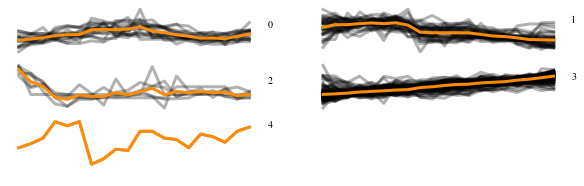

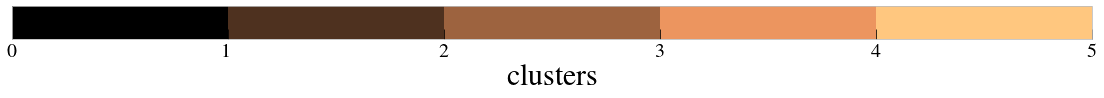

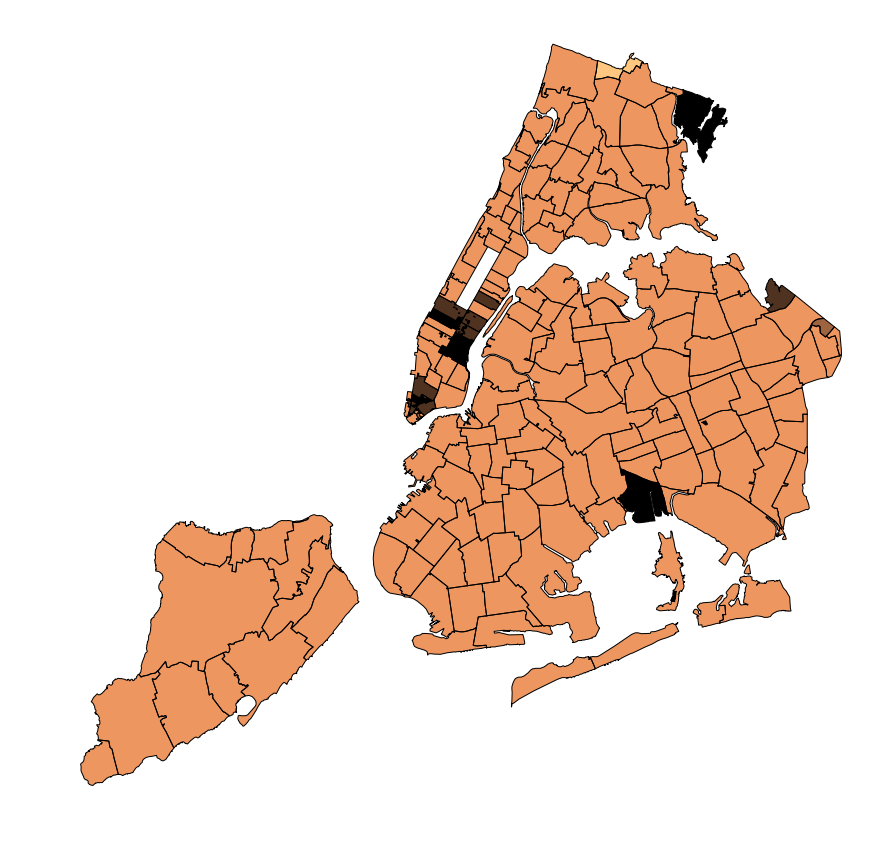

In [21]:
fig = pl.figure(figsize = (10,5))
for i,Xc in enumerate(centroidsag):
    ax = fig.add_subplot(5,2,(i+1))
    
    for v in vals[labelsag == i]:
        ax.plot(np.arange(1994,2014, 1),v, 'k-', alpha = 0.3)
    ax.text(2014.5, 1, "%d"%i)

    pl.xticks(fontsize = 10)
    ax.set_yticklabels([''*len(ax.get_xticklabels())])
    ax.plot(np.arange(1994,2014, 1), Xc, color = 'DarkOrange', lw=3)
    pl.grid(False)
    pl.axis('off')
fig = pl.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
cmap = mpl.cm.copper
norm = mpl.colors.Normalize(vmin=0, vmax=5)

#adding a color bar to identify the clusters on the map
# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar. 
bounds = range(nc+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                ticks=bounds,
                                spacing='uniform',
                                orientation='horizontal')
cb3.set_label('clusters', fontsize=30)
ax = pl.figure(figsize=(15,15)).add_subplot(111)
mergednyz_ag.plot(column='cluster', colormap=cmap, alpha = 1, axes=ax)
ax.axis('off')

#Comments

with 5 clusters agglomerative clustering finds a cluster of 1, i.e. an outlier (10470 in the Bronx, cluster 4), and a cluster of very few (cluster 2) but does not split the 2 trends of growth as we saw with K-means: the constant grows and the growth that slowed down in recent years. Next I will try to see if increasing the number of clusters these 2 trends are separated. Had I known that i was going to redo the hierarchical clustering I would have used a package (like sklearn clustering) that saves the lincage, or chosen a larger number of clusters to do the linkage and then only picked the 5 cluster level, but the clustering is really not that expensive and on my laptop it takes only a few seconds, so I am going to just redo it)

(0.0, 1.0, 0.0, 1.0)

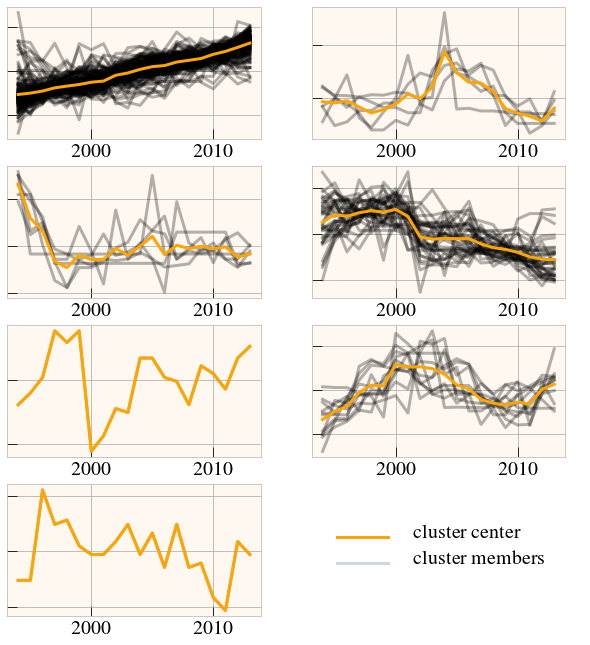

In [22]:
#trying 7 clusters
nc = 7
agc = AgglomerativeClustering(n_clusters=nc,  
                              linkage='average').fit(vals)
labelsag = agc.labels_
centroidsag = np.zeros((nc, vals.shape[1]))
                    
#colorsc3 = get_colors(np.arange(30), pl.cm.blues)
#colors3 = get_colors(labelsag, pl.cm.blues)
for i in labelsag:
    centroidsag[i] = getCentroid(vals[labelsag == i])


fig = pl.figure(figsize = (10,20))
for i,Xc in enumerate(centroidsag):
    ax = fig.add_subplot(7,2,(i+1))
    
    for v in vals[labelsag == i]:
        ax.plot(np.arange(1994,2014, 1),v, 'k-', alpha = 0.3)


    ax.set_yticklabels([''*len(ax.get_xticklabels())])
    ax.plot(np.arange(1994, 2014, 1), Xc, color="Orange", lw=3)
    pl.xticks(fontsize = 20)
    ax.set_xlim(1993.1, 2013.9)
    
ax = fig.add_subplot(7, 2, i+2)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.plot([0.1, 0.3], [0.4, 0.4], '-', alpha = 0.3)
ax.plot([0.1, 0.3], [0.6, 0.6], '-', color='Orange')
ax.text(0.4, 0.6, "cluster center", fontsize=20)
ax.text(0.4, 0.4, "cluster members", fontsize=20)
ax.axis('off')    


In [23]:
for j in range(nc):
    print ("zipcodes in cluster", j, )
    print (cleannyczips[labelsag==j])
    print ("\n\n\n\n")
    
clustersdf = gp.GeoDataFrame()
clustersdf['postalCode'] = cleannyczips
clustersdf['cluster'] = labelsag

zipcodes in cluster 0
[11372 11004 11040 11426 11365 11373 11001 11375 11427 11374 11366 11423
 11428 11432 11379 11429 11435 11415 11418 11433 11221 11421 11419 11434
 11216 11416 11233 11436 11213 11212 11225 11218 11226 11219 11210 11230
 11204 10471 10466 10467 10463 10475 10469 10468 10458 10034 10033 10462
 10040 10453 10465 10461 10457 10460 10032 10452 10456 10472 10031 10039
 10459 10451 10473 10030 10027 10474 10455 10037 10024 10454 10026 10035
 10025 11357 10029 11356 11359 11360 11105 10128 11371 10023 10028 11354
 11102 11370 11361 11358 11362 10044 11369 11103 11106 11368 11377 11355
 11101 11364 10018 10001 10011 11104 11109 11367 10014 10003 11222 10002
 11378 10009 10012 11211 11237 11385 11206 11412 10005 11251 10004 11411
 11201 11205 11208 11207 11413 11217 11238 11231 11422 11420 11417 11215
 11232 11430 11203 11239 11236 11220 10301 10310 10303 11234 10302 11693
 11209 10304 10314 11228 11096 10305 11229 11214 11691 11223 11692 11235
 10306 11694 11224 10308 1169

244 244 247


//anaconda/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
//anaconda/lib/python3.5/site-packages/geopandas/plotting.py:229: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


(-74.283564678453331,
 -73.67179689147234,
 40.474873729366841,
 40.93613362698175)

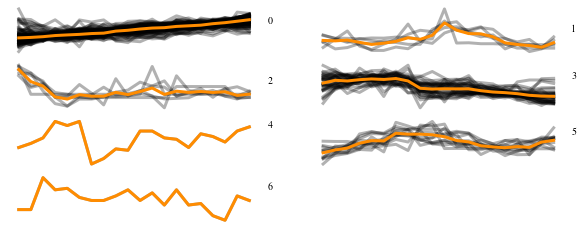

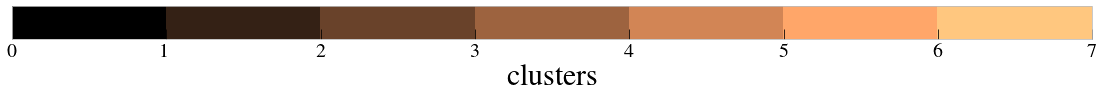

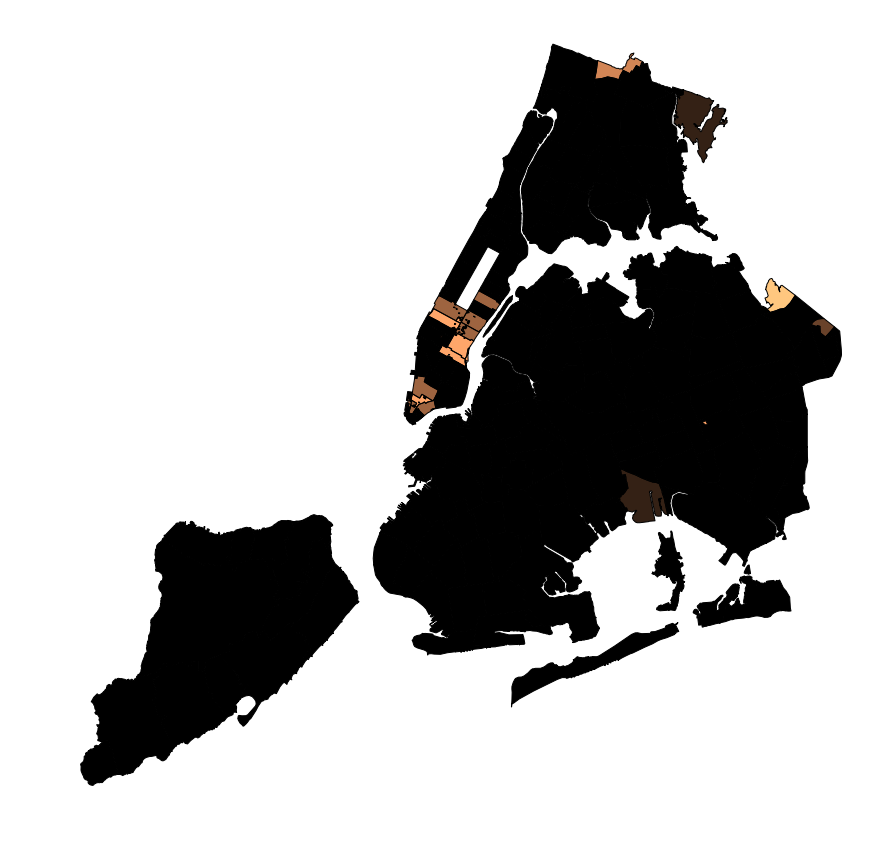

In [24]:
mergednyz_ag = nyczipsshp.merge(clustersdf, on='postalCode', how='inner')
print (len(mergednyz_ag.postalCode), len(np.unique(clustersdf.postalCode)), 
    len(np.unique(nyczipsshp.postalCode)))
fig = pl.figure(figsize = (10,5))
for i,Xc in enumerate(centroidsag):
    ax = fig.add_subplot(5,2,(i+1))
    
    for v in vals[labelsag == i]:
        ax.plot(np.arange(1994,2014, 1),v, 'k-', alpha = 0.3)
    ax.text(2014.5, 1, "%d"%i)

    pl.xticks(fontsize = 10)
    ax.set_yticklabels([''*len(ax.get_xticklabels())])
    ax.plot(np.arange(1994,2014, 1), Xc, color = 'DarkOrange', lw=3)
    pl.grid(False)
    pl.axis('off')
fig = pl.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
cmap = mpl.cm.copper
norm = mpl.colors.Normalize(vmin=0, vmax=5)

#adding a color bar to identify the clusters on the map
# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar. 
bounds = range(nc+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                ticks=bounds,
                                spacing='uniform',
                                orientation='horizontal')
cb3.set_label('clusters', fontsize=30)
ax = pl.figure(figsize=(15,15)).add_subplot(111)
mergednyz_ag.plot(column='cluster', colormap=cmap, alpha = 1, axes=ax)
ax.axis('off')

#Comments
Increasing the number of clusters isolated a few more outliers, but it did not split the upword trend in a constant growth, and a growth that slowed down in recent years, so I am going to dismiss that and believe that it was not a robust separation.

There is an insteresting cluster (1) that shows a significant injection of establishments in 2005. Interestingly the cluster is not spatially close, but it includes: a large ZIP in the Bronx (10464) a large ZIP in Howard Beach (11414) a midtown one (10055) and two in the financial district. 

11005 10105 10104 10158 10196 10275 are identified by a steep decreas in the first 5 year, which seems robust and significant (by visual inspection of the time sreies). These ZIPs are in Manhattan for the most part, except 1105 in Queens and 10196, which I could not identify (a bug in my code somwehre?) 

10470 remains an outlier. Another outlier is identified in 11363 (Queens)

With more time, I would inverstigate the economic history of NYC around 2005, and in the second half of the 90s.

For now, I just want to make sure the clusters I see are robust to noise. For that I will smooth the time series with a rolling mean filter before clustering. The window size I choose is only 3 years, since I only have 20 datapoints. To avoid NaN's in my data I allow the rolling mean function to return the time series value at the edges (1993, 1994 and 2012, 2013).

In [25]:
#what if i smooth the time series to decrease noise?
cleansmooth = pd.rolling_mean(cleancsb, 3, min_periods=1, axis=1)

vals_smooth = ((cleansmooth.T - cleansmooth.mean(1))/cleansmooth.std(1)).T

print ("i expect means of each row to be = 0", vals_smooth.mean(1)[:10])
print ("i expect stds of each row to be = 1", vals_smooth.std(1)[:10])


i expect means of each row to be = 0 [ -4.21884749e-16  -5.55111512e-17   3.77475828e-16  -1.70974346e-15
   7.10542736e-16   1.96509475e-15  -5.15143483e-15  -1.90958360e-15
   4.10782519e-16  -1.18793864e-15]
i expect stds of each row to be = 1 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


(0.0, 1.0, 0.0, 1.0)

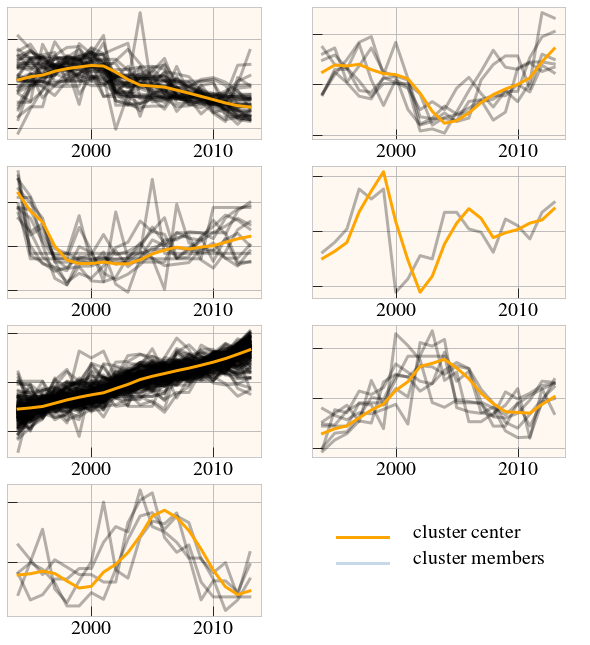

In [26]:
nc = 7
agc = AgglomerativeClustering(n_clusters=nc,  
                              linkage='average').fit(vals_smooth)
labelsag = agc.labels_
centroidsag = np.zeros((nc, vals_smooth.shape[1]))
                    
#colorsc3 = get_colors(np.arange(30), pl.cm.blues)
#colors3 = get_colors(labelsag, pl.cm.blues)
for i in labelsag:
    centroidsag[i] = getCentroid(vals_smooth[labelsag == i])


fig = pl.figure(figsize = (10,20))
for i,Xc in enumerate(centroidsag):
    ax = fig.add_subplot(7,2,(i+1))
    #notice i plot the original time series, not the smooth ones    
    for v in vals[labelsag == i]:
        ax.plot(np.arange(1994,2014, 1),v, 'k-', alpha = 0.3)


    ax.set_yticklabels([''*len(ax.get_xticklabels())])
    ax.plot(np.arange(1994, 2014, 1), Xc, color="Orange", lw=3)
    pl.xticks(fontsize = 20)
    ax.set_xlim(1993.1, 2013.9)
    
ax = fig.add_subplot(7, 2, i+2)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.plot([0.1, 0.3], [0.4, 0.4], '-', alpha = 0.3)
ax.plot([0.1, 0.3], [0.6, 0.6], '-', color='Orange')
ax.text(0.4, 0.6, "cluster center", fontsize=20)
ax.text(0.4, 0.4, "cluster members", fontsize=20)
ax.axis('off')    


In [27]:
for j in range(nc):
    print ("zipcodes in cluster", j, )
    print (cleannyczips[labelsag==j])
    print ("\n\n\n\n")
    
clustersdf = gp.GeoDataFrame()
clustersdf['postalCode'] = cleannyczips
clustersdf['cluster'] = labelsag

zipcodes in cluster 0
[11363 10021 10017 10010 10013 10038 10006 10048 10165 10118 10176 10019
 10111 10170 10122 10107 10103 10166 10169 10152 10270 10271 10110 10175
 10151 10173 10178 10121 10123 10106 10022 10043 10096 10265 10047 10080
 10260 10285 10281]





zipcodes in cluster 1
[10168 10153 10177 10172 10154 10155]





zipcodes in cluster 2
[11426 10471 11005 11236 10310 10105 10104 10158 10120 10196 10275 10203]





zipcodes in cluster 3
[10470]





zipcodes in cluster 4
[11372 11004 11040 11365 11373 11001 11375 11427 11374 11366 11423 11428
 11432 11379 11429 11435 11415 11418 11433 11221 11421 11419 11434 11216
 11416 11233 11436 11213 11212 11225 11218 11226 11219 11210 11230 11204
 10466 10467 10463 10475 10469 10468 10458 10034 10033 10462 10040 10453
 10465 10461 10457 10460 10032 10452 10456 10472 10031 10039 10459 10451
 10473 10030 10027 10474 10455 10037 10024 10454 10026 10035 10025 11357
 10029 11356 11359 11360 11105 10128 11371 10023 10028 11354 11102 11370


244 244 247


//anaconda/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
//anaconda/lib/python3.5/site-packages/geopandas/plotting.py:229: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


(-74.283564678453331,
 -73.67179689147234,
 40.474873729366841,
 40.93613362698175)

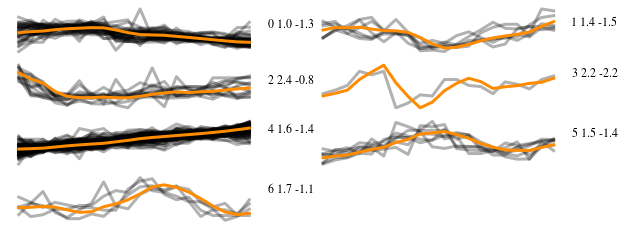

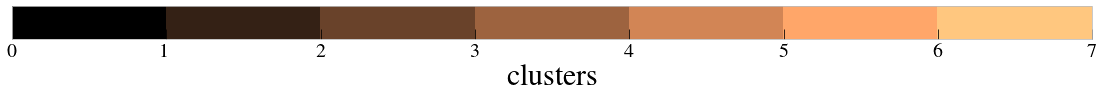

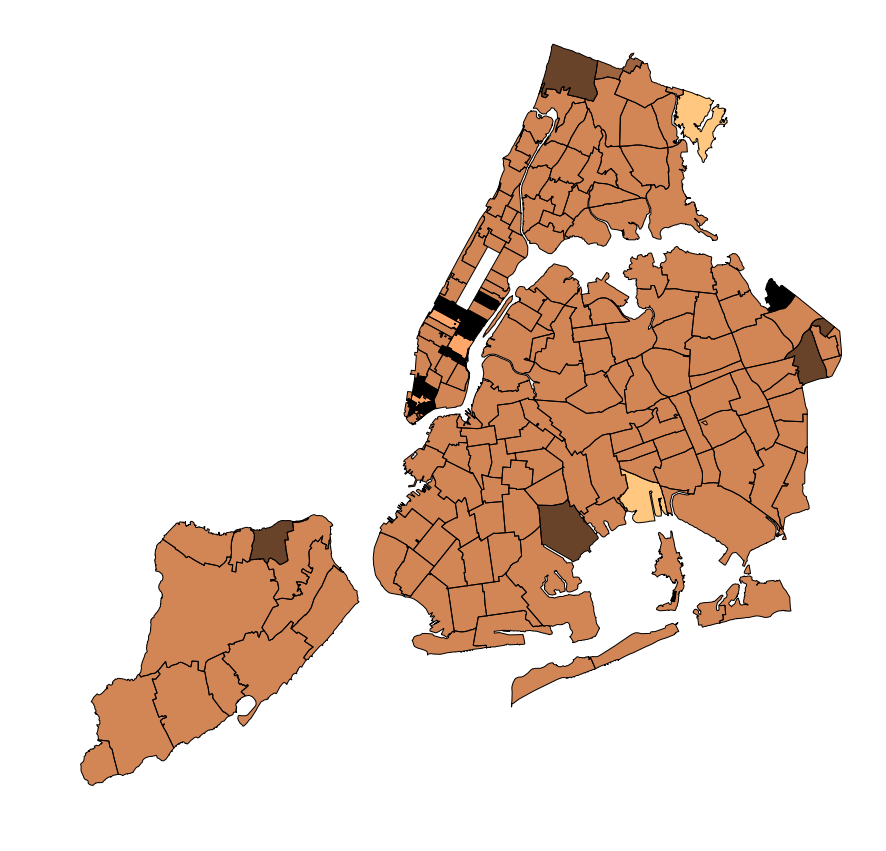

In [28]:
mergednyz_ag = nyczipsshp.merge(clustersdf, on='postalCode', how='inner')
print (len(mergednyz_ag.postalCode), len(np.unique(clustersdf.postalCode)), 
       len(np.unique(nyczipsshp.postalCode)))
fig = pl.figure(figsize = (10,5))
for i,Xc in enumerate(centroidsag):
    ax = fig.add_subplot(5,2,(i+1))
    #notice i plot the original time series, not the smooth ones
    for v in vals[labelsag == i]:
        ax.plot(np.arange(1994,2014, 1),v, 'k-', alpha = 0.3)

    pl.xticks(fontsize = 10)
    ax.set_yticklabels([''*len(ax.get_xticklabels())])
    ax.plot(np.arange(1994,2014, 1), Xc, color = 'DarkOrange', lw=3)
    ax.text(2014.5, 1, "%d %.1f %.1f"%(i, max(Xc),min(Xc)), fontsize=12)
    pl.grid(False)
    pl.axis('off')
fig = pl.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
cmap = mpl.cm.copper
norm = mpl.colors.Normalize(vmin=0, vmax=5)

#adding a color bar to identify the clusters on the map
# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar. 
bounds = range(nc+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                ticks=bounds,
                                spacing='uniform',
                                orientation='horizontal')
cb3.set_label('clusters', fontsize=30)
ax = pl.figure(figsize=(15,15)).add_subplot(111)
mergednyz_ag.plot(column='cluster', colormap=cmap, alpha = 1, axes=ax)
ax.axis('off')

#Conclusions:

1) most of the city has been in constant economic growth, as measured by the number of establishments, since 1994 (cluster 4, with a mean slope of 0.2)

2) a significant fraction of zip codes suffered a slow down, since 2000 (cluster 0) mostly these are zips in Manhattan midtown and financial district, and a single zip code in queens: 11363.

3) zip code 10470, in the bronx, seems to have a different behavior than any other NYC zips. A quick google search shows that it is an upscale zip code in the Bronx(identified in some web sites as the best place to live in the Bronx), so a reasonable outlier.

4) interesting patterns that should be investigated include the initial economic decline of individual zips distributed in the various boroughs (Queens, Bronx, SI), the economic injections in 2005 for a few zip codes in Queens and midtown.

The metric of economic growth, the number of establishments, is partial and biased (toward small business) and its validity should be investigated.

Lastly, since the dataset is small (N~200) we can plot a full dendrogram and see the hierarchical structure. 


NonGuiException: 

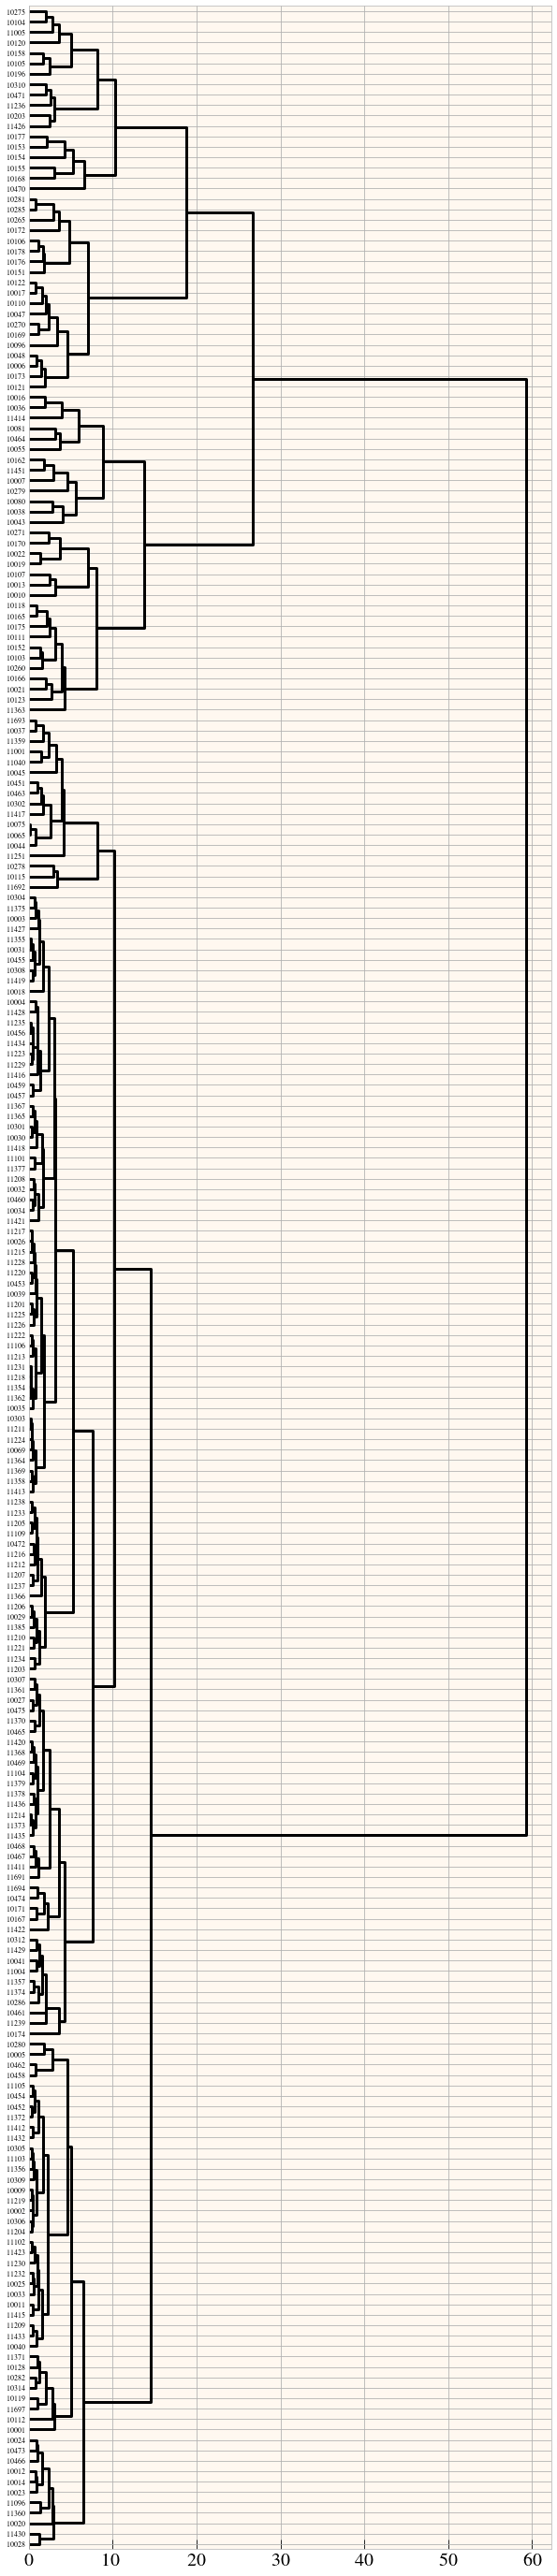

In [30]:
fig = pl.figure(figsize=(10,50))

ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals_smooth, method='ward'),
                               labels = mergednyz_ag.postalCode.values,
                               #leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8, color_threshold = 0, 
                               orientation='right', 
                               above_threshold_color='k'
                              )  # font size for the x axis labels)
pl.xlabel("distance", fontsize=20)
pl.grid('off')
#scp.hierarchy.dendrogram?
